In [1]:
# detrender in a notebook

# should be run in same directory as democratic_detrender
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
from scipy.interpolate import interp1d
from scipy.stats import median_abs_deviation
from matplotlib.widgets import Slider, Button
import sys, argparse
import os
import warnings
import ast
import lightkurve as lk

# democratic detrender specific functions
from get_lc import tic_id_from_simbad, transit_info_from_exoplanet_archive, determine_cadence, find_nearest


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/diana/Documents/cornell_research/hotjupiter_orbitaldecay/Code/uhj/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/diana/.lightkurve/cache. Please move all the files in the legacy directory /Users/diana/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


# Grabber

First, we download the desired light curve files and save to disk.

pi men c - not sure if that'll be queryable - so i'll use its TOI, TOI-144.

This section also pre-processes light curve data for the detrender.

In [2]:
name = 'TOI-144'

In [3]:
# let's see what tic_id_from_simbad will get us
tic_id = tic_id_from_simbad(name)
tic_id

'TIC 261136679'

Great, we have TIC 261136679!

Now, let's pull in the transit metadata from the NASA Exoplanet Archive. This includes period, mid-transit time, and duration.

Note that since there are 3 planetary candidates orbiting pi men, we'll get three entries.

In [4]:
transit_info = transit_info_from_exoplanet_archive(tic_id)
print(transit_info)

Exoplanet Archive: Planet Comparison Table
------------------------------------------
             tic_id      t0 [BJD]  period [days]  duration [hours]
1338  TIC 261136679  2.458633e+06    2088.800000               NaN
1339  TIC 261136679  2.458520e+06       6.267852             2.969
1340  TIC 261136679           NaN     124.640000               NaN


Which one is pi me c? Well we're going off what's listed on [exoplanets.eu....](https://exoplanet.eu/catalog/pi_men_c--6825/)

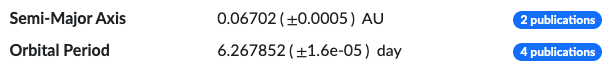

Ok, so it's planet #2 as listed in the NEA table!

Let's go ahead and download its light curves from MAST using lightkurve. We'll save the transit ephmeris for later. Actually, let's save that right now. We have to save the entire ephmeris for thw whole multi=planet system so lightkurve can pick out which transits belong to who later.

Here's a little dilemma: planet number 3, pi men d, doesn't have t0 or duration! This is because it has only been detected with RV. Let's throw it out:

In [5]:
# this bit automates throwing out planets that lack a t0 (lack of mid-transit time indicates we dont have transit data for it)
planets_without_transit_info = transit_info['t0 [BJD]'].isna()
# print(planets_without_transit_info)
if planets_without_transit_info.any(): # if resulting list does contain any Trues
    indices_to_remove = planets_without_transit_info.reset_index(drop=True).index[planets_without_transit_info]
    for idx in range(len(indices_to_remove)):
        print(
            "no t0 information on exoplanet archive for the "
            + str(indices_to_remove[idx] + 1)
            + "th/rd planet. Discarding this planet as it does not have transit data.")
    transit_info = transit_info[~planets_without_transit_info]
transit_info

no t0 information on exoplanet archive for the 3th/rd planet. Discarding this planet as it does not have transit data.


,tic_id,t0 [BJD],period [days],duration [hours]
1338,TIC 261136679,2.458633e+06,2088.800000,NaN
1339,TIC 261136679,2.458520e+06,6.267852,2.969


In [6]:
# planet_num = 2

# # save corresponding ephmeris from table
# period = np.array(transit_info["period [days]"].values, dtype=float)[planet_num - 1]
# t0 = np.array(transit_info["t0 [BJD]"].values, dtype=float)[planet_num - 1]
# duration = np.array(transit_info["duration [hours]"].values, dtype=float)[planet_num - 1]

# print(period, t0, duration)
periods = np.array(transit_info["period [days]"].values, dtype=float)
t0s = np.array(transit_info["t0 [BJD]"].values, dtype=float)
durations = np.array(transit_info["duration [hours]"].values, dtype=float)

# switch to TESS BJD
t0s = t0s - 2457000
print(periods, t0s, durations)

[2088.8         6.267852] [1632.6    1519.8068] [  nan 2.969]


Meanwhile, if we lack transit duration, detrender assumes a 2 hour duration, so let's do it here too:

In [7]:
# if no duration values input, just assume a 2 hour duration
for ii in range(0, len(durations)):
    if np.isnan(durations[ii]):
        print(
            "no duration information on exoplanet archive for the "
            + str(ii + 1)
            + "th planet"
        )
        print("assuming 2 hours for " + str(ii + 1) + "th planet duration!")
        durations[ii] = 2.0

no duration information on exoplanet archive for the 1th planet
assuming 2 hours for 1th planet duration!



Now let's download and save the lightcurves!

In [19]:
# It's good to define a directory to save raw light curve files to
save_raws_to = './pi_men_c/'

# # pull in short cadence TESS SPOC light curve
# lc_files = lk.search_lightcurve(
#     tic_id, mission="TESS", author="SPOC", cadence="short"
# ).download_all(quality_bitmask='default', flux_column'pd
# lc_files

# we are going to download both short and long cadence TESS SPOC lightcurves

# pull in short cadence TESS SPOC LC
lc_files_short_cadence = lk.search_lightcurve(
    tic_id, mission="TESS", author="SPOC", cadence="short"
).download_all(quality_bitmask="default", flux_column='sap_flux', download_dir=save_raws_to)

# pull in long cadence TESS SPOC LC
lc_files_long_cadence = lk.search_lightcurve(
    tic_id, mission="TESS", author="SPOC", cadence="long"
).download_all(quality_bitmask="default", flux_column='sap_flux', download_dir=save_raws_to)

# use short cadence TESS data if if exists, else use long cadence
if lc_files_short_cadence == []:
    lc_files = lc_files_long_cadence
else:
    lc_files = lc_files_short_cadence


/Users/diana/Documents/cornell_research/hotjupiter_orbitaldecay/Code/uhj/lib/python3.9/site-packages/lightkurve/search.py:495: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


<div> 
<img src="attachment:e6854e08-24c1-4aed-a34f-be20693bb9e2.png" width="1500"/>
</div>
Great, it's all in there.

Now let's look at sectors (named quarter in the code because it was originally developed for Kepler data).

In [22]:
# pull in start and end times, crowding, and flux_fraction values for each quarter
quarters = []
crowding = []
flux_fraction = []
for file in lc_files:
    quarters.append([np.min(file.time.value), np.max(file.time.value)])
    crowding.append(file.CROWDSAP)
    flux_fraction.append(file.FLFRCSAP)

print(f'{len(quarters)} sectors in this light curve.')

# stitch quarters together
lc = lc_files.stitch().remove_nans()

xs = lc.time.value
ys = lc.flux
ys_err = lc.flux_err

20 sectors in this light curve.


In [108]:
# now let's create a transit mask
nplanets = len(periods)
planet_number = 2 # number of planet we want
mask_width = 1.3 # assume a mask width of 1.3 times the duration of the transit
print(periods[planet_number-1], durations[planet_number-1], t0s[planet_number-1])


mask = np.zeros(np.shape(xs), dtype=bool)
for ii in range(0, nplanets):
    masks = lc.create_transit_mask(
        period=periods[ii],
        duration=durations[ii] / 24.0 * mask_width,
        transit_time=t0s[ii],
    )
    mask += masks
print('\n')
mask_fitted_planet = lc.create_transit_mask(
    period=periods[planet_number - 1],
    duration=durations[planet_number - 1] / 24.0 * mask_width,
    transit_time=t0s[planet_number - 1],
)


6.267852 2.969 1519.806799999904
2088.8 0.10833333333333334 1632.6000000000931
1044.4
[False False False ... False False False]
6.267852 0.16082083333333333 1519.806799999904
3.133926
[False False False ... False False False]


6.267852 0.16082083333333333 1519.806799999904
3.133926
[False False False ... False False False]


In [64]:
# save the period, duration, and t0 for the planet we are fitting for...
period = np.array([periods[planet_number - 1]])
t0 = t0s[planet_number - 1]
duration = np.array([durations[planet_number - 1]])

print("using the following params for the planet we are fitting")
print("--------------------------------------------------------")
print("[  t0 [TESS BJD]  , P [days], tdur [hrs]")
print("[" + str(t0) + ", " + str(period[0]) + ", " + str(duration[0]) + "]")

using the following params for the planet we are fitting
--------------------------------------------------------
[  t0 [TESS BJD]  , P [days], tdur [hrs]
[1519.806799999904, 6.267852, 2.969]


In [109]:
#create transit masks and 
min_time = xs.min()
max_time = xs.max()
t0s_all = []
while t0 > min_time:
    t0 -= period[0]

while t0 < max_time:
    t0s_all.append(t0)
    #print(t0s_all)
    t0 += period[0]

cadence = determine_cadence(xs)

t0s_in_data = []
for t0 in t0s_all:
    nearest_lc_time = find_nearest(xs, t0)

    # if there is a data point within the cadence (times some uncertainty lets say 3) of
    # expected transit then there should be transit data
    if np.abs(t0 - nearest_lc_time) < 3 * cadence:
        t0s_in_data.append(t0)
        
print(str(len(t0s_in_data)) + " transits (or epochs) in total")


78 transits (or epochs) in total


In [110]:
# normalize the data
mu = np.median(ys)
ys = ys / mu - 1
ys_err = ys_err / mu

In [111]:
# then create a dataframe
lc = pd.DataFrame({
    'xs': np.array(xs),
    'ys': np.array(ys),
    'ys_err': np.array(ys_err),
    'mask': mask,
    'mask_fitted_planet': mask_fitted_planet
})

lc

,xs,ys,ys_err,mask,mask_fitted_planet
0,1325.296960,-0.000278,0.000089,False,False
1,1325.298349,-0.000181,0.000089,False,False
2,1325.299738,-0.000173,0.000089,False,False
3,1325.301127,-0.000160,0.000089,False,False
4,1325.302516,-0.000236,0.000089,False,False
...,...,...,...,...,...
327199,3717.911352,-0.000230,0.000088,False,False
327200,3717.912741,-0.000069,0.000088,False,False
327201,3717.915519,-0.000052,0.000088,False,False
327202,3717.921075,0.000198,0.000088,False,False


In [112]:
lc_metadata = pd.DataFrame({
    'quarters': quarters,
    'crowding': crowding,
    'flux_fraction': flux_fraction
})

lc_metadata

,quarters,crowding,flux_fraction
0,"[1325.2969604950604, 1353.1770658972157]",0.999658,0.980012
1,"[1410.9021106108596, 1436.848821132188]",0.999678,0.979242
2,"[1517.3459676643836, 1541.9992030242654]",0.999516,0.979421
3,"[1596.778222427207, 1623.892585575971]",0.999631,0.980480
4,"[1624.9564805509808, 1652.892818686888]",0.999674,0.981524
5,"[1653.9219847347993, 1682.3580011391293]",0.999673,0.979437
6,"[2036.280140803426, 2060.64241664855]",0.999678,0.980753
7,"[2061.8521281940903, 2087.0975152114343]",0.999652,0.980602
8,"[2144.5142293514655, 2169.942906865684]",0.999660,0.979120
9,"[2361.772906030508, 2389.7188940229244]",0.999670,0.981591


In [113]:
orbital_data = pd.DataFrame({
    't0': t0,
    'period': period,
    'duration': duration,
})

orbital_data   

,t0,period,duration
0,3713.555,6.267852,2.969


In [114]:
t0s_output = pd.DataFrame({
    't0s_in_data': t0s_in_data
})

t0s_output

,t0s_in_data
0,1325.503388
1,1331.771240
2,1338.039092
3,1344.306944
4,1350.574796
...,...
73,3161.984024
74,3174.519728
75,3694.751444
76,3701.019296


In [115]:
# Save the DataFrames as CSV files
save_to = 'pi_men_c/'

lc.to_csv(save_to+'lc.csv', index=False)
lc_metadata.to_csv(save_to+'lc_metadata.csv', index=False)
orbital_data.to_csv(save_to+'orbital_data.csv', index=False)
t0s_output.to_csv(save_to+'t0s_output.csv', index=False)


In [59]:
# insert way to get out individual light curve files instead here

# Detrender

Now we're on to the big leagues!

In [2]:
# democratic detrender input parameters - all the arguments are explicitly listed, plus their default values
# there's some special handling involved but the argument string i wrote should take care of it

# let's load in our own light curve in the user_light_curve argument
# let's also load in input_period, input_t0, and input_duration

# parsing parameter csv here:
orbital_data = pd.read_csv('./pi_men_c/orbital_data.csv')
print(orbital_data)
print(orbital_data['t0'].values[0])

####     ~~~official arguments start here~~~     ####

object_id = 'TOI-144' # TESS or Kepler identifier, ex: "toi-2088"
flux_type = 'pdc' # Flux type as a string; options: pdc, sap, both, or qlp
mission = 'TESS' # Mission data select, etc, TESS
planet_num = 2 # planet num to look at in system
save_to_dir = './pi_men_c/' # directory to save CSVs and figures to
depth = 0.01

# can either supply these transit ephemeris yourself or let detrender grab it from Exoplanet Archive\
# alternatively, if you have your own light curve you'd like to use, ignore these variables 
# and fill in the path for user_light_curve
input_period = orbital_data['period'].values[0] # optionally input period, defaults to what Exoplanet Archive can find, default: None
input_t0 = orbital_data['t0'].values[0] # optionally input t0, defaults to what Exoplanet Archive can find, default: None
input_duration = orbital_data['duration'].values[0] # optionally input transit duration, defaults to what Exoplanet Archive can find, default: None

# mask
mask_width = 1.3 # sets mask width; default is 1.3

# data/plot handling options
show_plots = True # set whether to show non-problem-time plots (i.e outlier plots)
dont_bin = False # if True, then problem time plots data wont be binned
save_transit_data = False # if True, then will save data on each transit

# detrending method handling options
# these should be all set to True unless you specifically want to esclude certain detrending methods
polyam = True
cofiam = True
local = True
gp = True

# problem time handling
use_sap_problem_times = False # use SAP problem times for PDC. True or False.
no_pdc_problem_times = True #  assume PDC needs no problem times.

# user light curve option
user_light_curve = './pi_men_c/' # path to directory with user input light curve and metadata, default is 'NO'

         t0    period  duration
0  3713.555  6.267852     2.969
3713.5549999998857


In [3]:
# storing arguments in a long string to pass to detrender
arguments = (
    f"{object_id} "
    f"--flux_type {flux_type} "
    f"--mission {mission} "
    f"--planet_num {planet_num} "
    f"--save_to_dir {save_to_dir} "
    f"-d {depth} "
    f"{f'-p {input_period} ' if input_period else ''}"
    f"{f'-t {input_t0} ' if input_t0 else ''}"
    f"{f'-du {input_duration} ' if input_duration else ''}"
    f"-mw {mask_width} "
    f"--show_plots {show_plots} "
    f"--dont_bin {dont_bin} "
    f"--save_transit_data {save_transit_data} "
    f"--polyAM {polyam} "
    f"--CoFiAM {cofiam} "
    f"--local {local} "
    f"--GP {gp} "
    f"--use_sap_problem_times {use_sap_problem_times} "
    f"--no_pdc_problem_times {no_pdc_problem_times} "
    f"--user_light_curve {user_light_curve}"
)


In [5]:
print(arguments)

TOI-144 --flux_type pdc --mission TESS --planet_num 2 --save_to_dir ./pi_men_c/ -d 0.01 -p 6.267852 -t 3713.5549999998857 -du 2.969 -mw 1.3 --show_plots True --dont_bin False --save_transit_data False --polyAM True --CoFiAM True --local True --GP True --use_sap_problem_times False --no_pdc_problem_times True --user_light_curve ./pi_men_c/


LOADING USER LIGHT CURVE and METDATA FROM LOCAL DIRECTORY: ./pi_men_c/


/Users/diana/Documents/cornell_research/hotjupiter_orbitaldecay/Code/uhj/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/diana/Documents/cornell_research/hotjupiter_orbitaldecay/Code/uhj/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


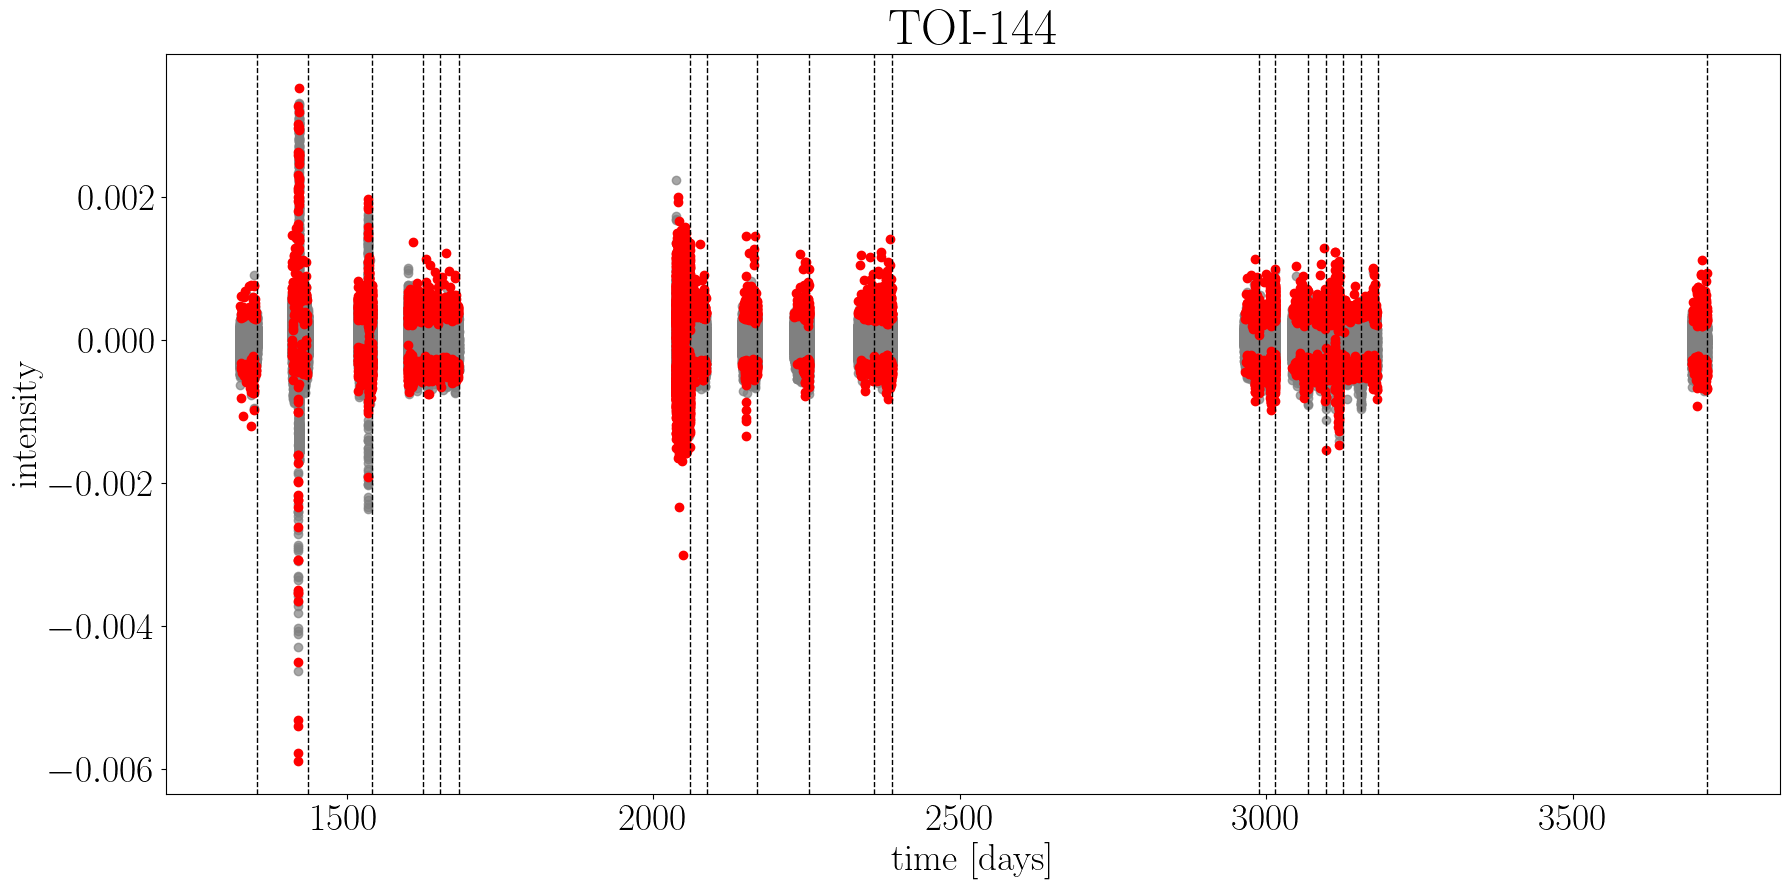

0
[1325.2969605  1325.29834936 1325.29973823 ... 1353.17289933 1353.17428819
 1353.17567704]
1
[1410.90211061 1410.90349947 1410.90488832 ... 1436.40994056 1436.41132943
 1436.41271829]
2
[1517.98069907 1517.98208798 1517.98347689 ... 1541.99503628 1541.99642519
 1541.99781411]
3
[1599.15188232 1599.15327124 1599.15466015 ... 1623.88841886 1623.88980777
 1623.89119667]
4
[1628.064853   1628.0662419  1628.06763081 ... 1652.88865202 1652.89004091
 1652.8914298 ]
5
[1653.92198473 1653.92337362 1653.92476251 ... 1682.35383452 1682.35522339
 1682.35661227]
6
[2036.2801408  2036.28291857 2036.28430746 ... 2059.76881792 2059.77020679
 2059.77159566]
7
[2061.85212819 2061.85351707 2061.85490594 ... 2085.619769   2085.62115786
 2085.62254672]
8
[2144.51422935 2144.51561821 2144.51700707 ... 2169.93874027 2169.94012913
 2169.941518  ]
9
[2361.77290603 2361.77429494 2361.77568384 ... 2389.71472735 2389.71611624
 2389.71750513]
10
[2229.11349194 2229.11488084 2229.11626974 ... 2254.05963841 2254.0

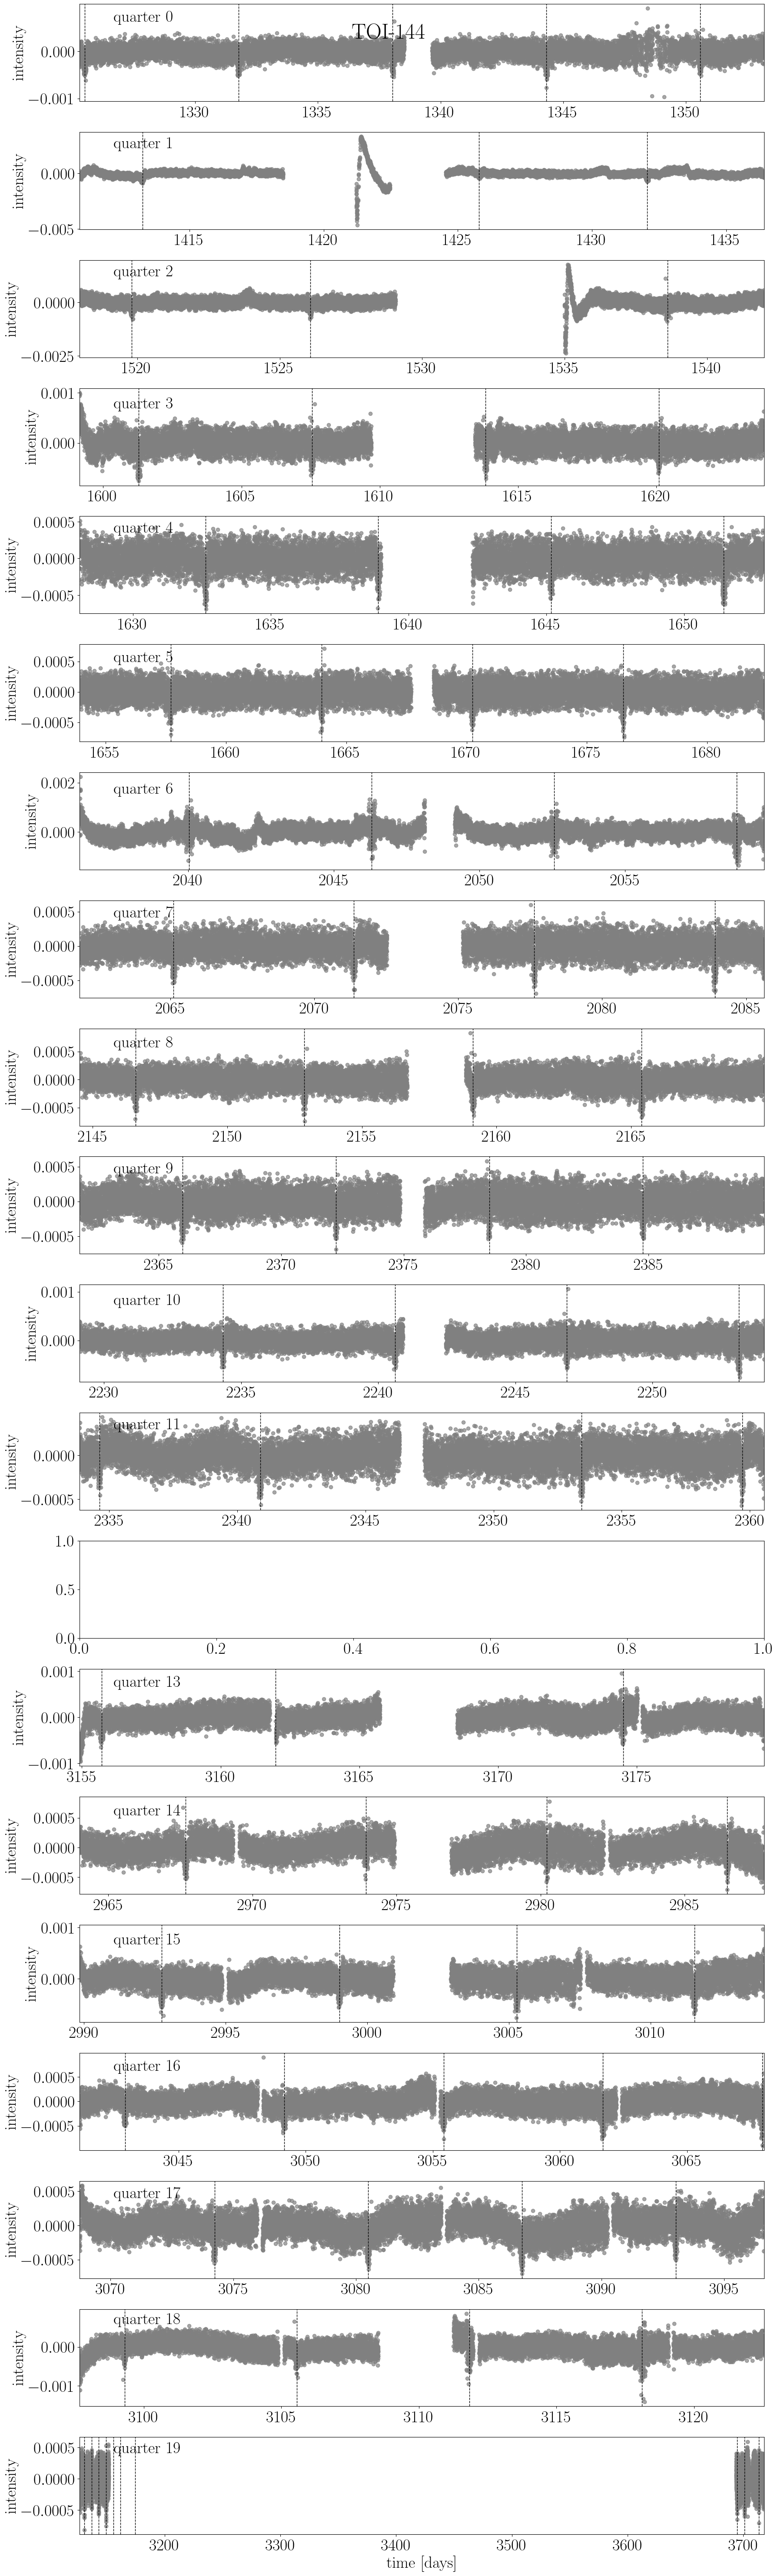

0
[1325.2969605  1325.29834936 1325.29973823 ... 1353.17289933 1353.17428819
 1353.17567704]
[-2.7763844e-04 -1.8143654e-04 -1.7327070e-04 ...  3.9815903e-05
  1.7321110e-04  1.7881393e-06]
1
[1410.90211061 1410.90349947 1410.90488832 ... 1436.40994056 1436.41132943
 1436.41271829]
[-1.4340878e-04 -8.6188316e-05  6.4730644e-05 ... -8.6784360e-05
 -2.8878450e-04 -3.8141012e-04]
2
[1517.98069907 1517.98208798 1517.98347689 ... 1541.99503628 1541.99642519
 1541.99781411]
[ 4.0185452e-04  3.4034252e-04 -3.6418438e-05 ...  5.1379204e-05
  6.7353250e-05  1.4793873e-04]
3
[1599.15188232 1599.15327124 1599.15466015 ... 1623.88841886 1623.88980777
 1623.89119667]
[ 1.0049343e-03  9.3901160e-04  6.2704086e-04 ... -7.4684620e-05
  4.9829483e-05 -1.1885166e-04]
4
[1628.064853   1628.0662419  1628.06763081 ... 1652.88865202 1652.89004091
 1652.8914298 ]
[-1.3613701e-04  2.3329258e-04  1.1599064e-04 ... -3.7491320e-05
 -3.4987926e-05  8.8334080e-05]
5
[1653.92198473 1653.92337362 1653.92476251 ... 1

/Users/diana/Documents/cornell_research/hotjupiter_orbitaldecay/Code/uhj/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


polyAM detrending completed in 76.6 seconds

detrending via the GP method


optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 17283.86419847753 -> 17394.61636220486
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 32925.23958906312 -> 32981.26878574039
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 26753.861647168807 -> 26805.78818219764
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 32122.04433428075 -> 32160.53470835481
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 22818.105981739187 -> 22911.868168744055
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 27180.650402622574 -> 27479.213487699253
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 22027.800297540984 -> 22105.077306058225
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 32094.55793295589 -> 32387.825742661535
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 22431.03402647774 -> 22582.697339463022
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 28012.57931525639 -> 28303.771522550425
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 25231.91455328375 -> 26017.86816791711
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 23141.095713353654 -> 23430.34394992148
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 24641.587396374478 -> 24795.373895564677
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 16194.122395902235 -> 16285.027275856177
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 30383.10443264196 -> 30505.10412773882
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 29802.226721475727 -> 29850.47307045752
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 14681.355264848798 -> 14723.26900089531
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 29662.853608140063 -> 29735.209838081275
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 26249.821934218147 -> 26293.557402909446
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 30423.88207303827 -> 30486.940855264584
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 30522.476658394506 -> 30564.650349890777
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 24904.74279798677 -> 24963.76898889678
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 30738.659837179366 -> 30792.191574377644
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 15044.870515181317 -> 17714.074293500853
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 12129.106428869993 -> 14559.485878133315
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 15287.827676476601 -> 17727.54574789188
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 10252.40407010936 -> 11961.607779343063
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 32420.778903673174 -> 32455.53293704304
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 22048.255211667933 -> 22079.88743954887
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 28253.95971762961 -> 28311.102994711262
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 24108.603822970592 -> 24144.495880426406
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 26689.992963207762 -> 26717.253406102085
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 31373.17772510549 -> 31415.40655288206
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 20163.768981738245 -> 20229.958746382887
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 30385.522780968524 -> 30506.560660313917
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 33304.44340474255 -> 33367.60145970634
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 24390.197791385814 -> 24425.496939042845
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 31372.527401400712 -> 31413.269827711953
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 19030.583792883604 -> 19112.822740753145
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 20616.345207179136 -> 20666.226688429146
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 33127.518054600776 -> 33193.81968791376
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 32948.93176244556 -> 32997.066240735585


GP failed for the 42th epoch


optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 30971.742457676497 -> 31036.673142440082
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 28244.97495506779 -> 28331.950995736384
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 26951.403556298737 -> 27150.094989606238
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 29073.780875377975 -> 29162.896589112523
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 31501.641702583525 -> 31522.273321886958
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 22152.780933291848 -> 22165.448999977547
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 28155.35003719792 -> 28200.011897204862
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 21240.822420639804 -> 21290.68761380452
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 29461.071524576204 -> 29542.295665519134


optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 25171.048417567607 -> 25186.06020397719
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 23288.766629869264 -> 23460.537408012307
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 24834.59174404941 -> 25053.027422079565
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 25622.389556211 -> 25661.31672072762
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 31102.129972923478 -> 31167.459577207188
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 30490.705522897126 -> 30551.39185367151
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 28891.26370216578 -> 28922.736452392706
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 26594.42358042293 -> 26857.777906530315
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 31763.62966367377 -> 31876.037422930876
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 30729.870714430584 -> 30771.427100403438
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 31217.630021829667 -> 31289.593231536805
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 29642.725435036064 -> 29795.391923398933
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 25621.27619358935 -> 25671.773684503813
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 28720.66204401051 -> 28756.012387656006
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 15779.1649281577 -> 15805.114173709748
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 25241.523792234213 -> 25816.317328789697
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 31102.4452670958 -> 31144.363407275076
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 16252.138535449614 -> 16292.73058117698
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 29283.056815694166 -> 29339.43998790324
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 22847.77728007843 -> 22886.801664990166
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 19873.551589399736 -> 20028.760378306284
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 31153.300536174804 -> 31184.634549175007
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 29286.22159717304 -> 29403.51519533119
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 18014.24973830907 -> 18041.856312552794
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Optimization terminated successfully.
logp: 29285.184425059186 -> 29375.71545451118


GP failed for the 77th epoch


/Users/diana/Documents/cornell_research/hotjupiter_orbitaldecay/Code/uhj/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


GP detrending completed in 626.31 seconds

detrending via the CoFiAM method
CoFiAM failed for the 59th epoch
CoFiAM completed in 481.42 seconds


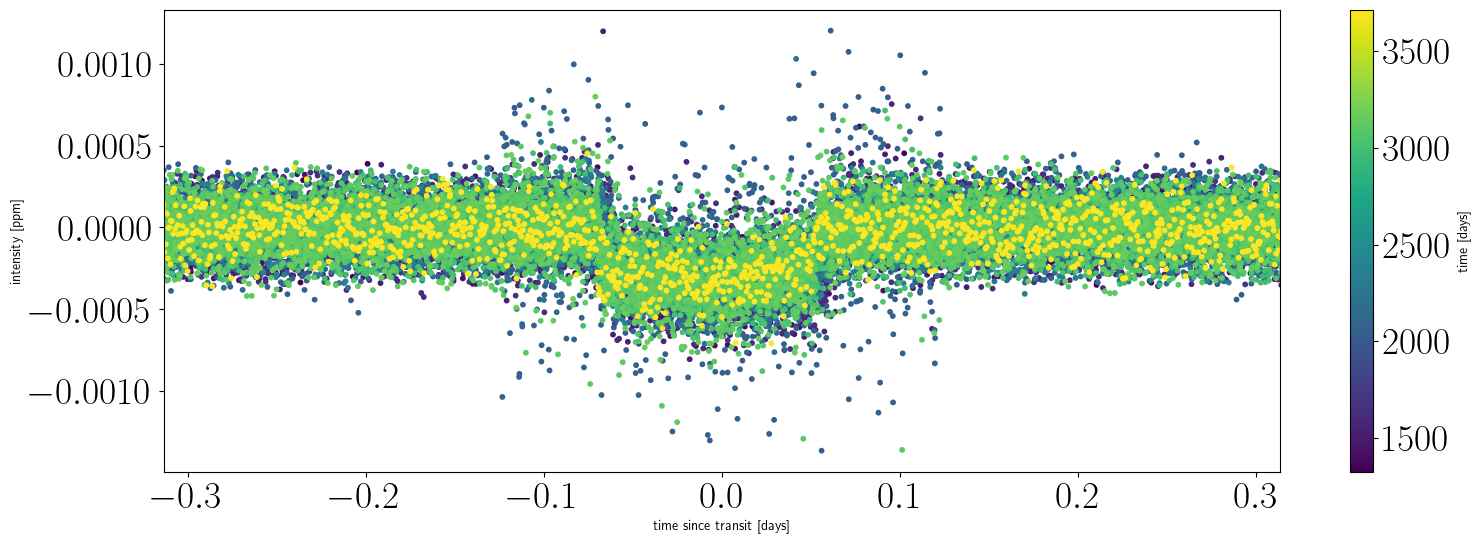

<Figure size 640x480 with 0 Axes>

In [4]:
# run the detrender
# ensures figures are displayed if user called for them to be displayed
%matplotlib inline 

# run the detrender
%run democratic_detrend.py {arguments}